In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx
from src.data.dataload import load_csv_folder_to_dataframe
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel
from sklearn.preprocessing import StandardScaler


In [2]:
## get data and preprocess
DATA_DIR = "data/raw"
df_loaded = load_csv_folder_to_dataframe(DATA_DIR)


Loading CSV files: 100%|██████████| 156/156 [02:59<00:00,  1.15s/file]


Load summary
- Files loaded: 156
- Total rows: 6125443
- Date range: 2012-12-31 23:00:00+00:00 to 2025-12-31 22:00:00+00:00
- Unique stations: 129


In [3]:
#only city data
df_city = df_loaded[df_loaded['domain_name']=='Stadt Ludwigsburg']
df_city['iso_timestamp'] = pd.to_datetime(df_city['iso_timestamp'], errors='coerce')

# smaller dataframe
df_city_small = df_city[['counter_site', 'iso_timestamp', 'channels_all', 'latitude', 'longitude']].copy()

C:\Users\Crabsi\AppData\Local\Temp\ipykernel_18132\1355442389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_city['iso_timestamp'] = pd.to_datetime(df_city['iso_timestamp'], errors='coerce')


In [4]:
# get nodes dictionary from city data
nodes_dict = {}
for counter_site in df_city_small['counter_site'].unique():
    df_temp = df_city_small[df_city_small['counter_site']==counter_site]
    lat = df_temp['latitude'].values[0]
    lon = df_temp['longitude'].values[0]
    nodes_dict[counter_site] = (lat, lon)
print(nodes_dict)

## center node for city
# latitude
center_lat = mean_lat = df_city['latitude'].mean()
# longitude
center_lon = mean_lon = df_city['longitude'].mean()  
center = (center_lat, center_lon)
center

# create mini dataframe
df_nodes = pd.DataFrame(nodes_dict).T
df_nodes.columns = ['lat', 'lon']


{'Marbacher Straße - Favoritepark': (np.float64(48.9024917455577), np.float64(9.195814132690431)), 'Alleenstraße': (np.float64(48.89318853889096), np.float64(9.192943238836945)), 'Marbacher Straße - Neckarbrücke': (np.float64(48.90732601393936), np.float64(9.2190957069397)), 'Schlieffenstraße': (np.float64(48.89376701735068), np.float64(9.164308905601503)), 'Fuchshof': (np.float64(48.89027528881407), np.float64(9.219911098480226)), 'Seestraße': (np.float64(48.8895134247259), np.float64(9.190567731857302)), 'Schlossstraße': (np.float64(48.90022430906293), np.float64(9.194172620773315)), 'Kesseläcker (Verl. Nussackerweg)': (np.float64(48.90177238337826), np.float64(9.17190492153168)), 'Zugwiesen': (np.float64(48.90932869563591), np.float64(9.240982532501222)), 'Solitudeallee': (np.float64(48.883562725714086), np.float64(9.182724952697756)), 'Aldinger Straße': (np.float64(48.88313941250021), np.float64(9.21056628227234)), 'Bottwartalstraße': (np.float64(48.90348261474315), np.float64(9.19

In [5]:
## omnsx part, first create graph with 3km buffer around center
G = ox.graph_from_point(center, dist=3000, network_type='bike')
# find the nearest node in the graph to the center point
center_node = ox.distance.nearest_nodes(G, X=center[1], Y=center[0])
# calculate shortest path lengths from center_node to all other nodes (we need this later)
lengths = nx.shortest_path_length(G, source=center_node, weight="length")

## then make a subgraph, because its easier to work with
# create a subgraph of all nodes within 3km of the center_node
subG = nx.ego_graph(
    G,
    center_node,
    radius=3000,
    distance="length"
)

# keep only the largest strongly connected components (parts where every node is reachable from every other node)
subG = subG.subgraph(
    max(nx.strongly_connected_components(subG), key=len)
).copy()

# we need some nodes that have to be included (from nodes dict!)
must_include_nodes = []

# find the nearest nodes in the graph for each of the specified lat/lon coordinates
for name, (lat, lon) in nodes_dict.items():
    nearest_node = ox.distance.nearest_nodes(subG, X=lon, Y=lat)
    must_include_nodes.append(nearest_node)

# calculate shortest path lengths from center_node to all other nodes in the subgraph
lengths2 = nx.single_source_dijkstra_path_length(subG, source=center_node, weight="length")

# now sort them by length
candidates = sorted(lengths2, key = lengths2.get)


In [6]:
# we want a minimum distance of 200m between selected nodes
MIN_DIST = 200
selected = []

# greedy selection of nodes ensuring minimum distance
for u in candidates:
    if not selected:
        selected.append(u)
        continue

    near = nx.single_source_dijkstra_path_length(
        subG, source=u, cutoff=MIN_DIST, weight="length"
    )
    if not any(n in near for n in selected):
        selected.append(u)

# our must_include nodes may not be in selected, so we add them now
final_selected = list(selected) 

# just add them to the final list if they are not already included
for n in must_include_nodes:
    if n not in final_selected:
        final_selected.append(n)

# check if all must_include_nodes are in the subgraph
for n in must_include_nodes:
    if n not in subG.nodes:
        print("existing nodes not in subgraph:", n)

# how many nodes did we select?
print("number of selected nodes:", len(final_selected))


number of selected nodes: 666


In [7]:
# map counter_site to node_id and get graph distances and hour
site_to_node = dict(zip(nodes_dict.keys(), must_include_nodes))
df_city_small['node_id'] = df_city_small['counter_site'].map(site_to_node)
df_city_small['graph_dist'] = df_city_small['node_id'].map(lengths2)
df_city_small['hour'] = pd.to_datetime(df_city_small['iso_timestamp']).dt.hour



In [8]:
## GP part
# group by node_id and hour to get mean and std of channels_all
df_gp = (
    df_city_small
    .groupby(['node_id', 'hour'], as_index=False)
    .agg(
        channels_mean=('channels_all', 'mean'),
        channels_std=('channels_all', 'std'),
        graph_dist=('graph_dist', 'first')
    )
)
df_gp['channels_std'] = df_gp['channels_std'].fillna(1.0)

# set up training data
X = df_gp[['graph_dist','hour']].values
y = df_gp['channels_mean'].values
noise = df_gp['channels_std'].values

# check shapes
print(X.shape, y.shape, noise.shape)

# our candidates must not include counter sites
observed_nodes = set(must_include_nodes)
all_nodes = set(final_selected)
candidate_nodes = list(all_nodes - observed_nodes)

# scale distance feature (scaling = standardization)
dist_scaler = StandardScaler()
X_train = X.copy()
X_train[:, 0] = dist_scaler.fit_transform(X[:, [0]]).ravel()

# define kernel with periodic component for hour of day
kernel = (
    RBF(length_scale=1.0) *
    ExpSineSquared(length_scale=1.0, periodicity=24) 
)

# create GP regressor with noise
gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise**2, 
    normalize_y=True
)
# fit GP to training data
gp.fit(X_train, y)
print("GP fitted with kernel:", gp.kernel_)

(360, 2) (360,) (360,)
GP fitted with kernel: RBF(length_scale=2.38e+04) * ExpSineSquared(length_scale=1.37e+03, periodicity=322)


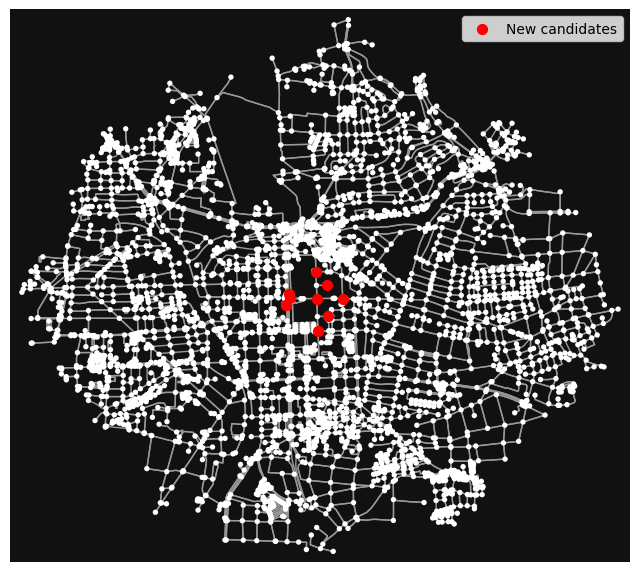

Observed distance range: 705.6967649844461 2998.8680242971886
96595588 0
1882531713 221.82897899984476
185964278 245.28482533703345
192191292 253.76045704223588
11091362372 257.328512157431
271635312 276.86594316303336
7867649076 300.92133324938254
1883486173 307.96766002272227
1069353294 365.20770457972696
5159244548 368.22282883441903


In [9]:
## now predict variance for candidate nodes
# first create candidate feature matrix
candidate_X = []

# for each candidate node, create 24 entries (one for each hour)
for node in candidate_nodes:
    dist = lengths2[node]
    for hour in range(24):
        candidate_X.append([dist, hour])
candidate_X = np.array(candidate_X)

# same scaling as for training 
candidate_X[:, 0] = dist_scaler.transform(candidate_X[:, [0]]).ravel()

# predict mean and std (and variance) for candidate nodes
mean, std = gp.predict(candidate_X, return_std=True)
variance = std**2

# now we want to score each candidate node by the maximum variance over the 24 hours
node_scores = {}
i = 0
for node in candidate_nodes:
    node_scores[node] = variance[i:i+24].max()
    i += 24

# now get top 10 nodes by score
top10 = sorted(node_scores.items(), key=lambda x: x[1], reverse=True)[:10]

top10_coords = [
    (node, subG.nodes[node]['y'], subG.nodes[node]['x'], score)
    for node, score in top10
]

# plot the subgraph and highlight the top 10 nodes
fig, ax = ox.plot_graph(subG, show=False, close=False)
lats = [subG.nodes[n]['y'] for n, _ in top10]
lons = [subG.nodes[n]['x'] for n, _ in top10]

ax.scatter(lons, lats, c='red', s=50, label='New candidates')
ax.legend()
plt.show()

# print some info about the selected nodes
min_dist = X[:, 0].min()
max_dist = X[:, 0].max()
print("Observed distance range:", min_dist, max_dist)
for node, score in top10:
    print(node, lengths2[node])

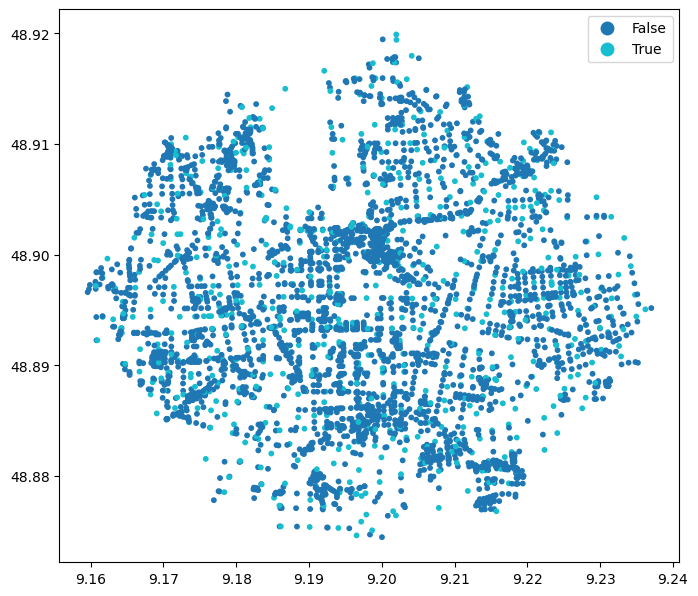

In [10]:
## visualization
# visualize the selected nodes
gdf = ox.graph_to_gdfs(subG, nodes=True, edges=False)
gdf["selected"] = gdf.index.isin(final_selected)

# plot the graph with selected and unselected nodes highlighted
ax = gdf.plot(
    column="selected",
    categorical=True,
    legend=True,
    figsize=(8,8),
    markersize=10
)

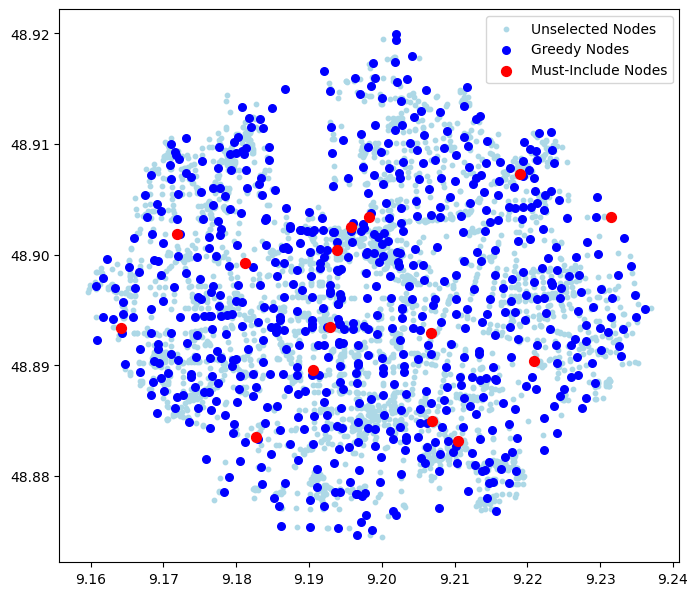

In [11]:
## visualization with selected, must-include and unselected nodes
gdf["greedy_selected"] = gdf.index.isin(selected)
gdf["must_include"] = gdf.index.isin(must_include_nodes)

fig, ax = plt.subplots(figsize=(8,8))
#gdf[gdf["greedy_selected"]].plot(ax=ax, color="blue", markersize=30, label="Greedy Nodes")
#gdf[gdf["must_include"]].plot(ax=ax, color="red", markersize=50, label="Must-Include Nodes")
gdf[~gdf["greedy_selected"] & ~gdf["must_include"]].plot(
    ax=ax, color="lightblue", markersize=10, label="Unselected Nodes", zorder=1
)
gdf[gdf["greedy_selected"]].plot(
    ax=ax, color="blue", markersize=30, label="Greedy Nodes", zorder=3
)
gdf[gdf["must_include"]].plot(
    ax=ax, color="red", markersize=50, label="Must-Include Nodes", zorder=4
)
plt.legend()
plt.show()

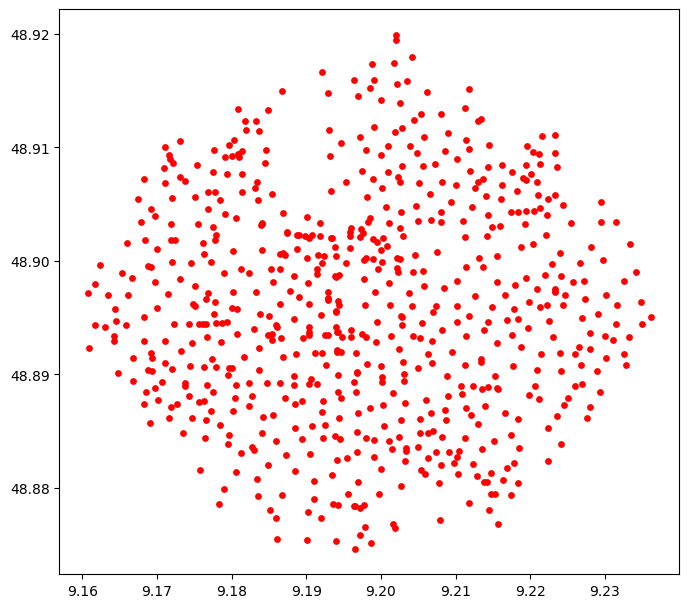

In [12]:
## visualization (only selected)
# plot only the selected nodes
selected_gdf = gdf[gdf["selected"]]

ax = selected_gdf.plot(
    color="red",
    markersize=15,
    figsize=(8,8)
)


In [13]:
## streetmaps visualization (just nice to have)
lengths = dict(lengths)

# drop very close nodes for better visualization
drop_keys = [k for k, v in lengths.items() if v < 200]
for k in drop_keys:
    lengths.pop(k)

# get nodes geodataframe
nodes = ox.graph_to_gdfs(G, edges=False)
print(nodes.head())
nodes["network_distance_m"] = nodes.index.map(lengths)

                  y         x  street_count highway railway  \
osmid                                                         
21585235  48.876969  9.196759             3     NaN     NaN   
21585238  48.878207  9.197236             3     NaN     NaN   
21585243  48.878757  9.195235             3     NaN     NaN   
21585249  48.880106  9.191582             3     NaN     NaN   
21585254  48.882566  9.190293             3     NaN     NaN   

                          geometry  
osmid                               
21585235  POINT (9.19676 48.87697)  
21585238  POINT (9.19724 48.87821)  
21585243  POINT (9.19523 48.87876)  
21585249  POINT (9.19158 48.88011)  
21585254  POINT (9.19029 48.88257)  


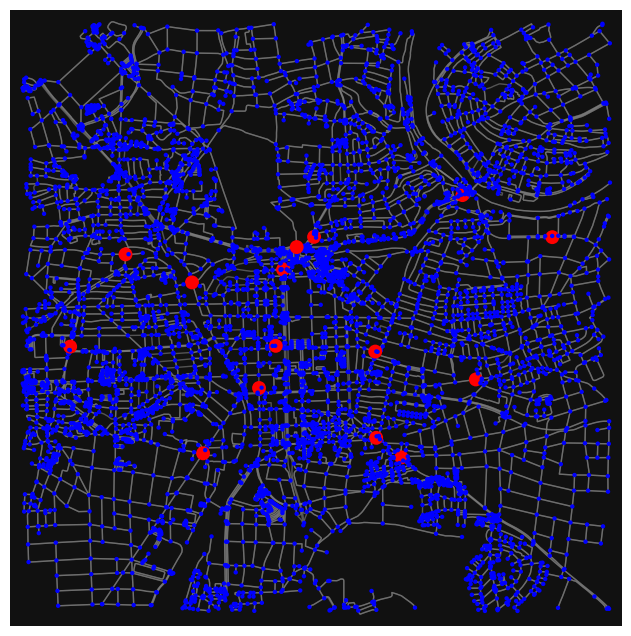

In [14]:
# plot graph with highlighted must_include nodes
node_colors = ['red' if n in must_include_nodes else 'blue' for n in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=[100 if n in must_include_nodes else 10 for n in G.nodes()],
    edge_color="gray",
    edge_alpha=0.6
)

In [15]:
all_lengths = {}
for site_node in must_include_nodes:
    lengths = nx.shortest_path_length(G, source=site_node, weight='length')
    all_lengths = lengths


all_lengths = dict(all_lengths)

drop_keys1 = [k for k, v in all_lengths.items() if v < 200]
for k in drop_keys1:
    all_lengths.pop(k)




In [16]:
min_dist_to_site = []
for n in G.nodes():
    dists = [all_lengths.get(n, np.inf) for site_node in must_include_nodes]
    min_dist_to_site.append(min(dists))

nodes['min_dist_to_site'] = min_dist_to_site
print(min(nodes['min_dist_to_site']))
nodes_finite = nodes[np.isfinite(nodes['min_dist_to_site'])].copy()
print(max(nodes_finite['min_dist_to_site']))

208.86389364623815
5441.479328205195


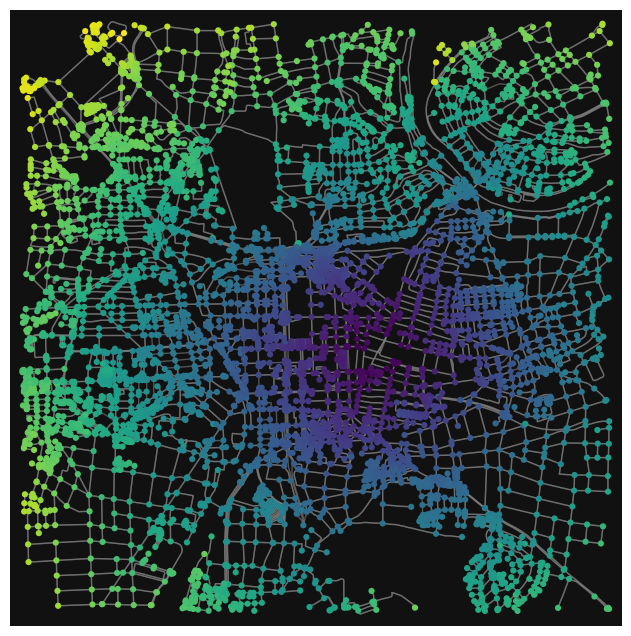

In [17]:
node_colors = nodes['min_dist_to_site'].values

fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=20,
    node_zorder=3,
    edge_color="gray",
    edge_alpha=0.6,
    show=True,
    close=False
)